<a href="https://colab.research.google.com/github/Skeletor-star/twiter--sentimental-analysis/blob/main/Twitter_sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud ### For visualising the frequent words
import re
import random
import string
import math
import itertools

# To mute general warnings


import warnings
warnings.filterwarnings('ignore')

## For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

## For building our Model
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Conv1D,Bidirectional,SpatialDropout1D,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam

## For creating vocabulary dictionary:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## For model evaluation:
from sklearn.metrics import confusion_matrix,classification_report

## For Text Processing:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
!pip install pyspellchecker
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 74.4 MB/s eta 0:00:00


In [ ]:
## Setting the seed to allow reproducibility
np.random.seed(31415)
tf.random.set_seed(2)

In [ ]:
plt.style.use('fivethirtyeight')

Reading DataFrame



In [ ]:
from google.colab import files
uploaded=files.upload()

Saving sample_data (2).csv to sample_data (2).csv


In [ ]:
df = pd.read_csv('sample_data (2).csv',encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#basic info
print(f"There are {df.shape[0]} ROWS and {df.shape[1]}")

There are 1600000 ROWS and 6


The dataset contains 1.6 M Tweets and I find it a good amount of data to train our model.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

In [ ]:
df["sentiment"].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [ ]:
### For ease of testing and computation
df = df.groupby('sentiment').apply(lambda x: x.sample(n=50000)).reset_index(drop = True)

df.sentiment.value_counts()

0    50000
4    50000
Name: sentiment, dtype: int64

In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
df.sentiment = df.sentiment.apply(lambda x: lab_to_sentiment[x])
df.head()

,sentiment,id,date,query,user_id,text
0,Negative,2259627954,Sat Jun 20 17:54:06 PDT 2009,NO_QUERY,pau_86,@carol_carter1 I don't think so I believe it ...
1,Negative,2055130076,Sat Jun 06 08:45:17 PDT 2009,NO_QUERY,baseball_mommy,"@nursebc1974 I know!!! My boys r wide awake, ..."
2,Negative,2060217645,Sat Jun 06 18:29:11 PDT 2009,NO_QUERY,hannuhhhx3,@Maddieeann either he didn't mean to send it t...
3,Negative,1969301425,Fri May 29 23:36:39 PDT 2009,NO_QUERY,TwistedEdge,@MSWindows I really wish microsoft would stop ...
4,Negative,2058365567,Sat Jun 06 14:47:42 PDT 2009,NO_QUERY,luuvasconcelos,@tommcfly I still think that brazilian's fans ...


Text(0.5, 1.0, 'Sentiment Target Distribution')

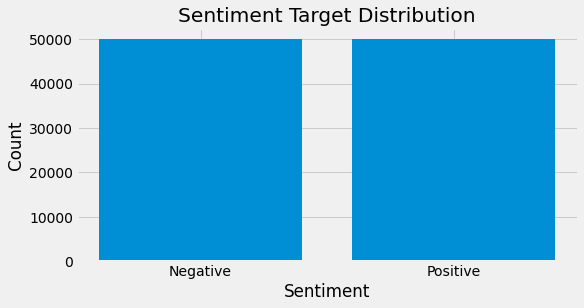

In [ ]:
### Visualising the distribution of the target variable.
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Target Distribution")

In [ ]:
### randomly selecting rows and printing them
ind=np.random.randint(0,1000,(10)) 
df.iloc[ind].text

842    The Veronicas were great! But its raining now ...
717    just got home after 2 classes. had a great tim...
996         @Anna_Montanna Yeah but it isn't activated. 
690    Cub run with sammers before she leaves for ric...
565      @Dunncity  It wasn't suppose to be that easy!!!
515    I better have something in the post....been 6 ...
687    finally get to use internet after 5 days. inte...
810      Blah moving sucks. Why do I have so much stuff 
47                             Ugh I'm not tired at all 
506    @Clumsyflic the kid that got a second chance s...
Name: text, dtype: object

In [ ]:
## Getting a list of stop words in English:
l_remove="don, don't, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, needn, needn't, shan, shan't, shouldn, shouldn't, wasn, wasn't, weren, weren't, won, won't, wouldn, wouldn't"
stop_words=[i for i in stopwords.words('english') if i not in l_remove.split(", ")]

#### Pattern removing Hyperlinks and Mentions:
pattern = "(@\S+)|(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"

## List of Punctuation marks:
punct=string.punctuation

## Setting a Stemmer Object:
stemmer = SnowballStemmer('english')
## Function to remove numbers:
def remove_numb(text):
    return re.sub("[0-9]+","",text)

In [ ]:
### Function for spelling-checker:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    ## Checks whether the corrected string is None, meaning there is no proper 
    ## spelling available.
    ct=[i for i in corrected_text if i is not None]
    if " ".join(corrected_text):
        return text
    else:
        return " ".join(corrected_text)

In [ ]:
### Stop words offered by NLTK:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
### Viewing the number of rows having MENTIONS:
v=[]
for i in df.text:
    v.append(re.findall(r'(@\S+)',i))   
    
v1=[i for i in v if len(i)!=0]
print(f"There are {len(v1)} rows with Mentions(@yyy) in their text")

There are 46180 rows with Mentions(@yyy) in their text


In [ ]:
### Viewing the number of rows having HYPERLINKS:
v=[]
for i in df.text:
    v.append(re.findall(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])',i))   

v2=[i for i in v if len(i)!=0]
print(f"There are {len(v2)} rows with Hyperlinks(http://yyy) in their text")

There are 4424 rows with Hyperlinks(http://yyy) in their text


In [ ]:
v1[:10]

[['@carol_carter1'],
 ['@nursebc1974'],
 ['@Maddieeann'],
 ['@MSWindows'],
 ['@tommcfly'],
 ['@KristinaDeFonte'],
 ['@afylayouts'],
 ['@Leanne0710'],
 ['@Hetty4Christ'],
 ['@MARCUS_KENNY']]

In [ ]:
v2[:10]

[[('http', 'plurk.com', '/p/xhfhf')],
 [('http', 'myloc.me', '/5ABP')],
 [('http', 'twitpic.com', '/7tsbt')],
 [('http', 'plurk.com', '/p/x88wx')],
 [('http', 'twitpic.com', '/6ou3m')],
 [('http', 'myloc.me', '/4NiF')],
 [('http', 'tinyurl.com', '/dy7lcy')],
 [('http', 'myloc.me', '/2IEY')],
 [('http', 'myloc.me', '/2QXk')],
 [('http', 'tr.im', '/oMSv')]]

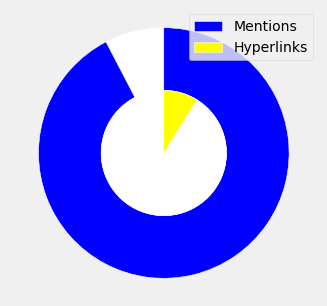

In [ ]:
labels = ["Mentions","Hyperlinks"]
data = [len(v1),len(v2)]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(math.log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ["blue","yellow"]

#create figure, axis
fig, ax = plt.subplots(figsize=(5,5))
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()


In [ ]:
def funct_clean(x,stem=False):
    ### Removing Mentions and Hyperlinks:
    sentence = re.sub(pattern, ' ', str(x).lower()).strip()
    ### Converting to lower case:
    sentence = sentence.lower()
    ### Removing punctuation marks:
    sentence=sentence.translate(str.maketrans('', '', punct))
    ### Tokenising:
    words = word_tokenize(sentence)
    tokens = []
    for token in words:
        if token not in stop_words:   ### Checking whether the token is a stop word
            if stem:
                tokens.append(stemmer.stem(token))  ### Stemming the token(Less time taken)
            else:
                tokens.append(token)

                 ## Removing numbers
    t1=remove_numb(" ".join(tokens)).split()
    ## can include the speller function while returning
    return t1

In [ ]:
 import nltk
 nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%%time

df["text_pre"] = df.text.apply(lambda x: funct_clean(x,1))

CPU times: user 19.9 s, sys: 2.3 ms, total: 19.9 s
Wall time: 22.3 s


In [ ]:
#### subset of the data to inspect::
data=df.iloc[:1000].copy()
data[["text","text_pre"]]

,text,text_pre
0,@carol_carter1 I don't think so I believe it ...,"[dont, think, believ, one, time]"
1,"@nursebc1974 I know!!! My boys r wide awake, ...","[know, boy, r, wide, awak, n, im, fallin, asleep]"
2,@Maddieeann either he didn't mean to send it t...,"[either, didnt, mean, send, hes, play, hard, get]"
3,@MSWindows I really wish microsoft would stop ...,"[realli, wish, microsoft, would, stop, push, s..."
4,@tommcfly I still think that brazilian's fans ...,"[still, think, brazilian, fan, better, alredi,..."
...,...,...
995,and when I got out my phone was dead :[[ it li...,"[got, phone, dead, live, week, ughh]"
996,@Anna_Montanna Yeah but it isn't activated.,"[yeah, isnt, activ]"
997,Aww i'm at retarded leadership shit,"[aww, im, retard, leadership, shit]"
998,@cehouck that's because we're like the same pe...,"[that, like, person, ahaha, ps, messag, wed, p..."


In [ ]:
df.columns

Index(['sentiment', 'id', 'date', 'query', 'user_id', 'text', 'text_pre'], dtype='object')

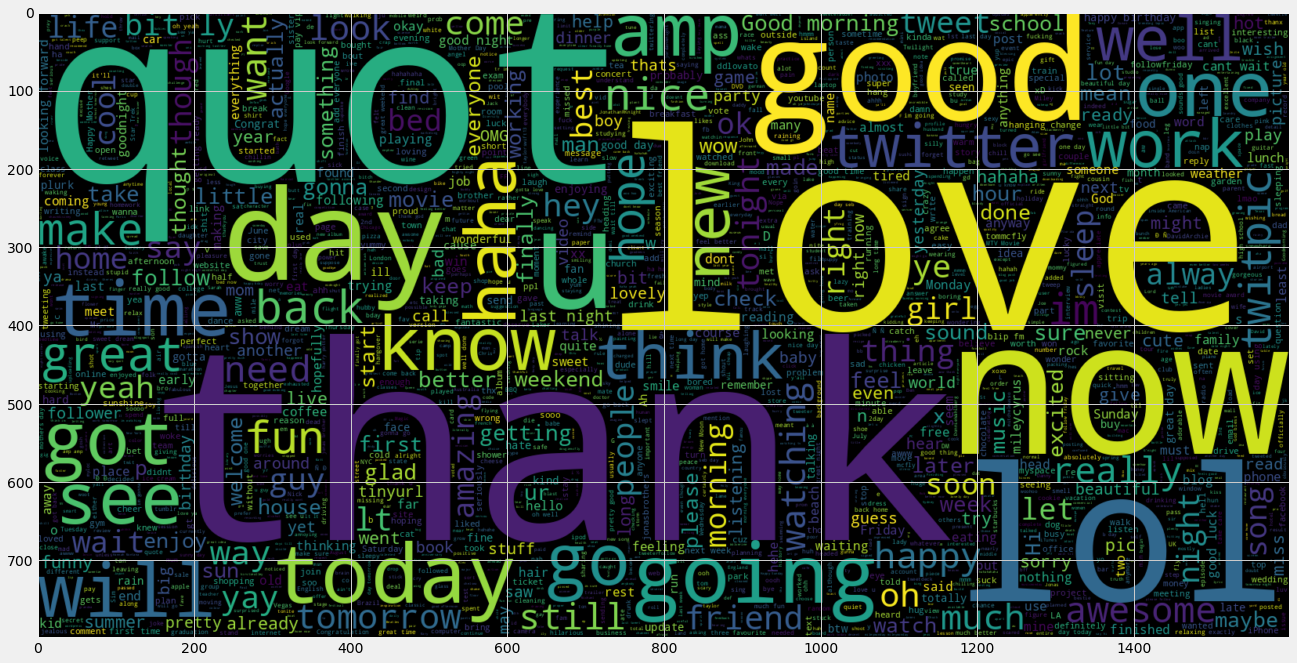

In [ ]:
## Top words from Positive Sentiment Tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

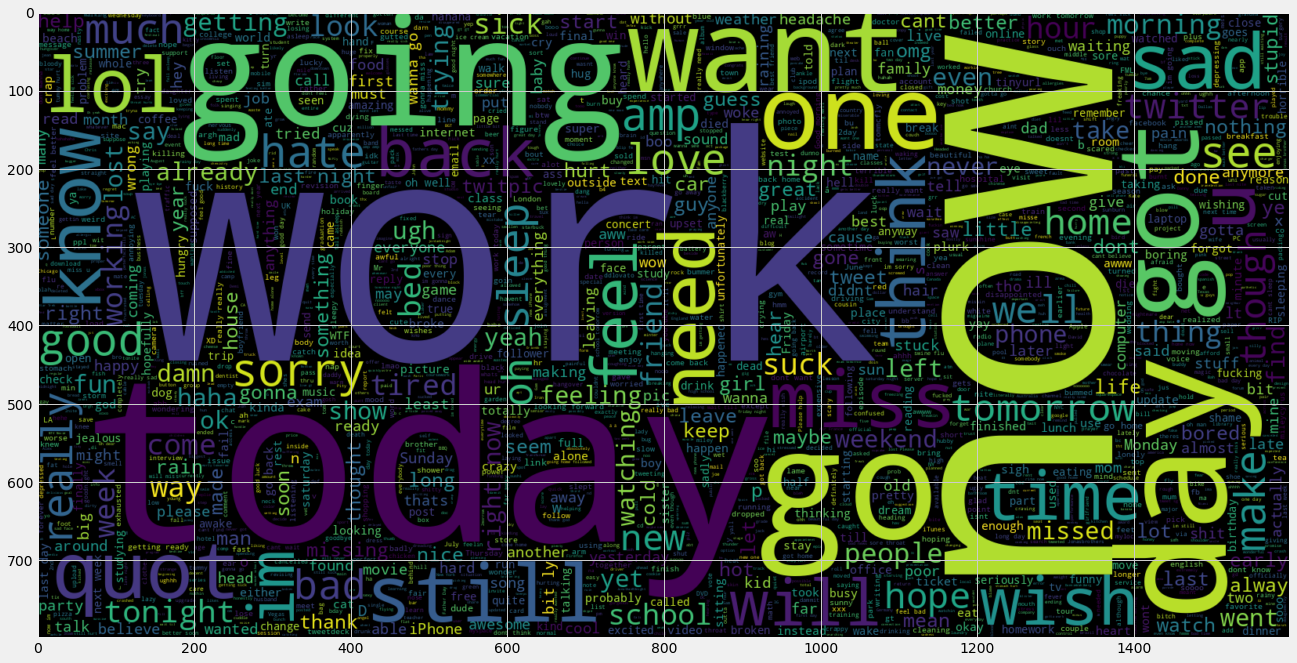

In [ ]:
## Top words from Negative Sentiment Tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

Splitting the dataset

In [ ]:
## Customisable Parameters:
MAX_NB_WORDS = 10000  ## 100000
MAX_SEQUENCE_LENGTH = 30  ## each document can be of max length 30

In [ ]:
train_data, test_data = train_test_split(df[["sentiment","text_pre"]], test_size=0.2,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 80000
Test Data size 20000


In [ ]:
train_data.head(10)

,sentiment,text_pre
91526,Positive,"[need, work, word, essay, chapter]"
19416,Negative,"[etsywiki, come, get, error, page]"
99079,Positive,"[absolut, blast, dont, rememb, harem, rememb, ..."
45086,Negative,"[final, exam]"
54659,Positive,"[lol, queen, victoria, precis]"
50266,Positive,"[still, unhappi, lack, guitar, string, realli,..."
62172,Positive,"[word, hannah, montana, nobodi, perfect]"
66637,Positive,"[like, cover, environment, scienc, book, haha]"
95845,Positive,"[ahhh, kim, kardashian, absolutelyy, love, any..."
98862,Positive,"[dont, feel, good, eat, dri, cheerio, like, li..."


In [ ]:
## Creating the Tokenizer Object:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text_pre) ## Whole text is passed into the object
### Tries to create a dictionary of vocabulary 

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("\nVocabulary Size :", vocab_size)  
## Means there are these many unique words in the dataframe


Vocabulary Size : 46834


In [ ]:
## Vocabulary Preview(Indexed Dictionary):
### Viewing the first 10 indexes::
for i,(j,k) in enumerate(word_index.items()):
    print(j,"-------->",k)
    if i==10:
        break

im --------> 1
go --------> 2
get --------> 3
day --------> 4
good --------> 5
work --------> 6
like --------> 7
love --------> 8
got --------> 9
dont --------> 10
today --------> 11


In [ ]:
## understanding what "texts_to_sequences" means:
def check_(to_check):
    print(f"-------------ROW {to_check}:---------------")
    print(f"The Train data is: {train_data.text_pre.iloc[to_check]}")
    print(f"The Vectorised Equivalent is: {tokenizer.texts_to_sequences(train_data.text_pre)[to_check]}\n")

check_(0)
check_(5)

-------------ROW 0:---------------
The Train data is: ['need', 'work', 'word', 'essay', 'chapter']
The Vectorised Equivalent is: [32, 6, 360, 1212, 2052]

-------------ROW 5:---------------
The Train data is: ['still', 'unhappi', 'lack', 'guitar', 'string', 'realli', 'wan', 'na', 'play', 'oh', 'well', 'hope', 'someon', 'excit', 'come', 'msn']
The Vectorised Equivalent is: [28, 3270, 1248, 802, 2892, 23, 102, 35, 86, 38, 27, 30, 171, 154, 37, 1004]



In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text_pre),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text_pre),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (80000, 30)
Testing X Shape: (20000, 30)


In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (80000, 1)
y_test shape: (20000, 1)


In [ ]:
%%time

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-03-29 16:55:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-29 16:55:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-29 16:55:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_path = 'glove.6B.300d.txt'
embedding_dim = 300   ### Controls the dimension size of the vector space
model_path = 'best_model.hdf5'

In [ ]:
embeddings_index = {}

### Processing the file
for line in open(glove_path):
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
### Creating an embedding matrix based on our Tokeniser object:
### vocab_size ---> Total unique words in our data
embedding_matrix = np.zeros((vocab_size, embedding_dim))  
for word, i in word_index.items():  ### unpacking the dictionary
    ### Checking whether the word exists in the pretrained embeddings_index
    embedding_vector = embeddings_index.get(word)  
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
### For viewing the vector space representation of any word present in the vocabulary
def funct_view_embedding(word):
    print(f"For the word \"{word}\", its respective vector representation in a 300 Dimensional Space is:")
    print("\n",embedding_matrix[word_index[f"{word}"]])

funct_view_embedding("hate")  ## since "love" is present in the vocabulary

For the word "hate", its respective vector representation in a 300 Dimensional Space is:

 [-2.70469993e-01 -1.65289998e-01 -3.15100013e-04  4.95669991e-01
 -7.42470026e-01  6.94469988e-01  2.07159996e-01  1.98300004e-01
  4.11300004e-01 -8.44240010e-01  4.24070001e-01  2.36770008e-02
  1.36910006e-01  1.81380004e-01  1.93440005e-01 -1.11520000e-01
  2.89229989e-01  5.45690000e-01  7.72870004e-01  4.27500010e-01
  4.46579993e-01  3.01600009e-01  2.14839995e-01  2.06540003e-01
 -4.31259990e-01  3.53530003e-03 -1.41770005e-01 -1.64039999e-01
  5.00199974e-01 -5.98980010e-01 -3.45039994e-01  9.12330002e-02
 -2.69510001e-01 -6.26200020e-01 -4.73690003e-01 -1.57389998e-01
 -3.67850006e-01 -1.86550006e-01 -1.40129998e-01  1.52250007e-01
  6.59359992e-01 -1.36099998e-02  3.78989995e-01 -2.46069998e-01
  3.09870005e-01 -4.35900003e-01 -1.81040004e-01  4.78949994e-01
  2.30930001e-01 -2.55320013e-01  3.24209988e-01  3.73459995e-01
 -1.01120003e-01 -2.31220007e-01 -5.10950029e-01  2.73519993e-01

In [ ]:
embedding_matrix.shape

(46834, 300)

In [ ]:
## Creating an Embedding Layer
embedding_layer = Embedding(vocab_size,embedding_dim,
                                        weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH, ### length of longest sentence
                                          trainable=False)

In [ ]:
## Learning Rate:
lr = 1e-2

## Creating the Layers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs) ## Model Object with input and output layers

## using the standard Adam as the optimiser(can be tweaked according to the user)
model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           14050200  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [ ]:
## Early Stopping object:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,mode="auto")

## Model Checkpoint Object:
checkpoint_path = 'model_checkpoints/'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
)

## Automatic learning rate update:

#monitor='val_loss' to use validation loss as performance measure to reduce the learning rate. 
#patience=2 means the learning rate is reduced as soon as 2 epochs with no improvement. 
#min_delta=0.001 means the validation loss has to improve by at least 0.001 for it to count as an improvement. 
#factor=0.2 means the new learning rate will be reduced as new_lr = lr * factor

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   
    patience=5, 
    min_lr=0.001,
    verbose=1
)

## Learning Rate Scheduler:
def lr_decay(epoch, lr):
    if epoch != 0 and epoch % 5 == 0:
        return lr * 0.2
    return lr

lrs=LearningRateScheduler(lr_decay, verbose=1)

Start trainging

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on CPU...


In [ ]:
batch_size = 1000
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_test, y_test), callbacks=[early_stopping,lrs])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/20
80/80 [==============================] - 65s 767ms/step - loss: 0.6105 - accuracy: 0.6618 - val_loss: 0.5531 - val_accuracy: 0.7156 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/20
80/80 [==============================] - 60s 750ms/step - loss: 0.5456 - accuracy: 0.7218 - val_loss: 0.5309 - val_accuracy: 0.7329 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/20
80/80 [==============================] - 62s 776ms/step - loss: 0.5202 - accuracy: 0.7422 - val_loss: 0.5276 - val_accuracy: 0.7379 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/20
80/80 [==============================] - 61s 769ms/step - loss: 0.5006 - accuracy: 0.7544 - val_loss: 0.5292 - val_accuracy: 0.7334 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.0

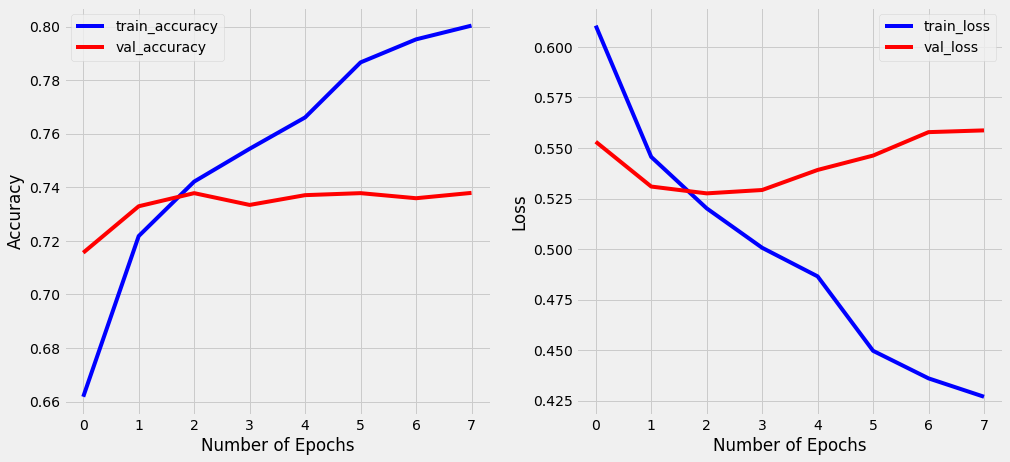

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
ax[0].plot(history.history['accuracy'],c= 'b',label="train_accuracy")
ax[0].plot(history.history['val_accuracy'],c= 'r',label="val_accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(history.history['loss'],c= 'b',label="train_loss")
ax[1].plot(history.history['val_loss'],c= 'r',label="val_loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=1000)
y_pred_1d = [decode_sentiment(score) for score in scores]

20/20 [==============================] - 5s 192ms/step


In [ ]:
### Plotting the normalised confusion matrix:

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.bwr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

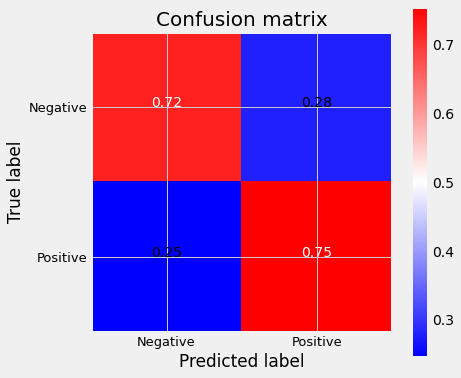

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [ ]:
## Classification report will give us an idea of important metrics like 
## precision,recall,accuracy,f1-score
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.75      0.72      0.73     10024
    Positive       0.73      0.75      0.74      9976

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

